In [575]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [576]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [577]:
url = "https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv"
df = pd.read_csv(url)

In [578]:
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [579]:
df["species"] = df["species"].replace("setosa", 0)
df["species"] = df["species"].replace("versicolor", 1)
df["species"] = df["species"].replace("virginica", 2)
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [580]:
x = df.drop('species', axis=1)
y = df['species']

In [581]:
x = x.values
y = y.values

In [582]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y ,
                                   random_state=100,
                                   test_size=0.2,
                                   shuffle=True)

In [583]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [584]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
x_train.shape, x_test.shape

(torch.Size([120, 4]), torch.Size([30, 4]))

In [585]:
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_train.shape, y_test.shape

(torch.Size([120]), torch.Size([30]))

In [586]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [605]:
# Hyperparameters
input_size = 4
hidden_size = 4
num_layers = 3
num_classes = 3
epochs = 100
learning_rate = 0.01

In [606]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, :]
        out = self.fc(out)
        return out

In [607]:
torch.manual_seed(91)
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [608]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [609]:
losses = []

for i in range(epochs):
  model.train()
  y_pred = model(x_train)
  loss = criterion(y_pred, y_train)
  losses.append(loss.item())
  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
print(f'Final Loss: {loss.item()}')

Epoch: 0 and loss: 1.2087253332138062
Epoch: 10 and loss: 0.9790717959403992
Epoch: 20 and loss: 0.759502112865448
Epoch: 30 and loss: 0.5789906978607178
Epoch: 40 and loss: 0.47623100876808167
Epoch: 50 and loss: 0.3749951720237732
Epoch: 60 and loss: 0.2617551386356354
Epoch: 70 and loss: 0.16729837656021118
Epoch: 80 and loss: 0.11914516240358353
Epoch: 90 and loss: 0.09221362322568893
Final Loss: 0.07804963737726212


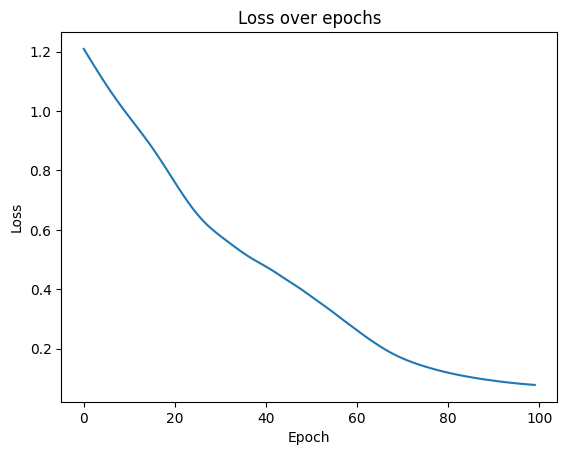

In [610]:
plt.plot(losses)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [611]:
from sklearn.metrics import accuracy_score
with torch.no_grad():
    train_pred = model(x_train)
    train_acc = accuracy_score(y_train.cpu().numpy(), train_pred.argmax(dim=1).cpu().numpy())
    print(f'Training Accuracy: {train_acc:.4f}')

Training Accuracy: 0.9917


In [612]:
with torch.no_grad():
    test_pred = model(x_test)
    test_acc = accuracy_score(y_test.cpu().numpy(), test_pred.argmax(dim=1).cpu().numpy())
    print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9667


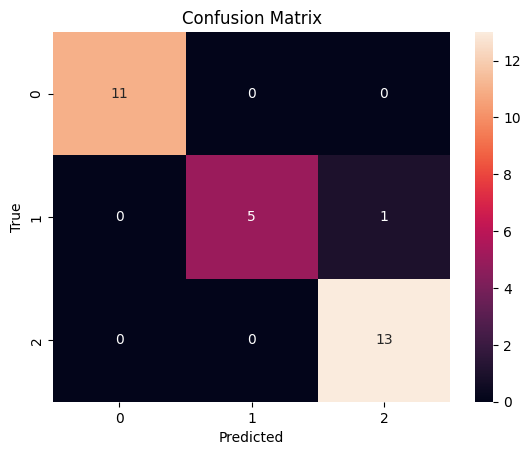

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.83      0.91         6
           2       0.93      1.00      0.96        13

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30



In [613]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model(x_test).argmax(dim=1).cpu().numpy()
confusion_mtx = confusion_matrix(y_test.cpu().numpy(), y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test.cpu().numpy(), y_pred))
